In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")


In [ ]:
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [ ]:
df = df.dropna()

In [ ]:
class_counts = df['Class'].value_counts()
print("\nDistribution of classes:")
print(class_counts)



Distribution of classes:
Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
# Menggabungkan X dan y ke dalam satu DataFrame untuk memudahkan pemrosesan
data = pd.DataFrame(X)
data['Class'] = y

# Memisahkan kelas mayoritas dan minoritas
data_majority = data[data['Class'] == 0]
data_minority = data[data['Class'] == 1]

# Mengambil sampel sebanyak 1000 dari kelas mayoritas
data_majority_sampled = data_majority.sample(n=1000, random_state=42)

# Menggabungkan kembali dataset yang telah disampling
data_balanced = pd.concat([data_majority_sampled, data_minority])

# Memisahkan kembali fitur dan label
X_balanced = data_balanced.drop('Class', axis=1).values
y_balanced = data_balanced['Class'].values

# Memeriksa distribusi kelas setelah penyeimbangan
print("Distribution of classes after balancing:")
print(pd.Series(y_balanced).value_counts())

# Membagi data menjadi training dan testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

# Standardisasi fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Mengubah data tabular menjadi bentuk 2D dengan padding untuk mencapai ukuran 32x32
num_features = X_train.shape[1]

# Membuat data memiliki 3 saluran
X_train_3ch = np.stack((X_train,)*3, axis=-1)
X_test_3ch = np.stack((X_test,)*3, axis=-1)

# Menambahkan padding untuk mencapai ukuran 32x32
X_train_padded = np.zeros((X_train_3ch.shape[0], 32, 32, 3))
X_test_padded = np.zeros((X_test_3ch.shape[0], 32, 32, 3))

# Memindahkan data yang diubah menjadi 3 saluran ke dalam array yang dipadukan
X_train_padded[:, :1, :num_features, :] = X_train_3ch[:, np.newaxis, :, :]
X_test_padded[:, :1, :num_features, :] = X_test_3ch[:, np.newaxis, :, :]

print("Shape of X_train_padded:", X_train_padded.shape)
print("Shape of X_test_padded:", X_test_padded.shape)

Distribution of classes after balancing:
0    1000
1     492
Name: count, dtype: int64
Shape of X_train_padded: (1044, 32, 32, 3)
Shape of X_test_padded: (448, 32, 32, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

input_shape = (32, 32, 3)

# Menggunakan VGG16 tanpa layer fully connected di bagian atas
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Membekukan layer base_model

# Menambahkan layer di atas base_model
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(2, activation='softmax')(x)  # 2 kelas

model = Model(inputs=base_model.input, outputs=outputs)

# Mengompilasi model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Menggunakan Early Stopping untuk mencegah overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Melatih model
history = model.fit(X_train_padded, y_train, epochs=100, batch_size=32, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])


58889256/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

14/14 [==============================] - 0s 23ms/step - loss: 0.3812 - accuracy: 0.8973
Loss: 0.3811834156513214, Accuracy: 0.8973214030265808
14/14 [==============================] - 0s 19ms/step
Prediksi: [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 1
 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1
 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1
 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 1 0
 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 

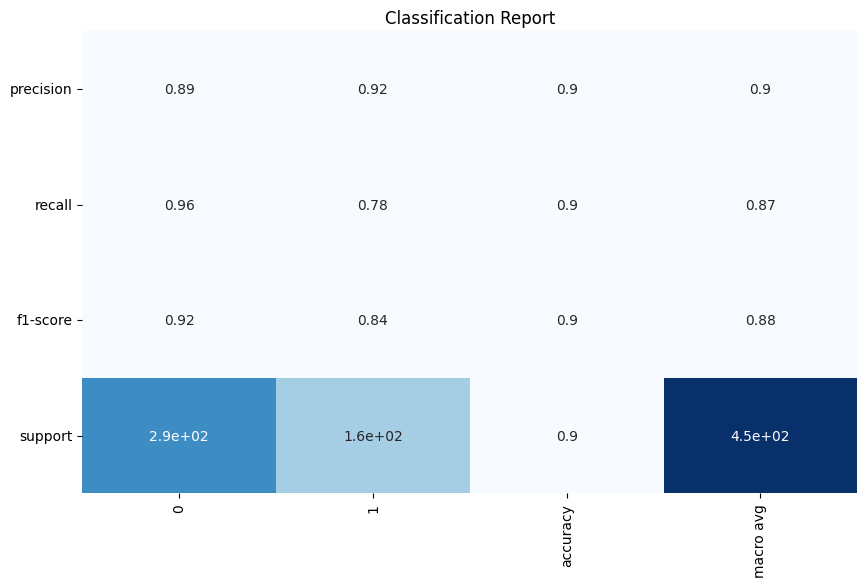

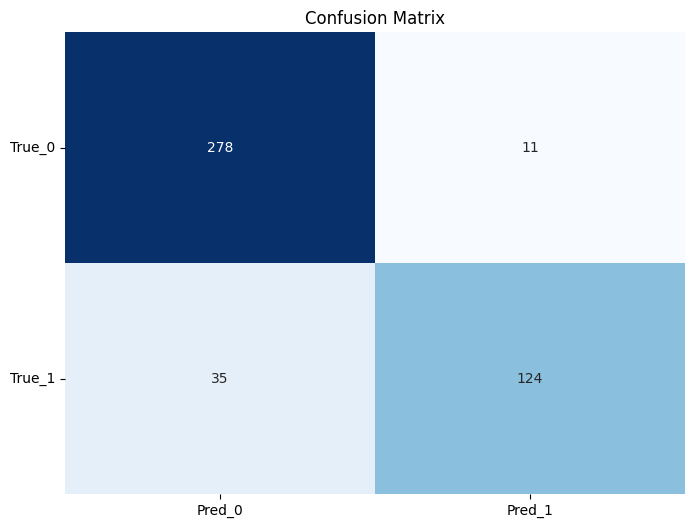

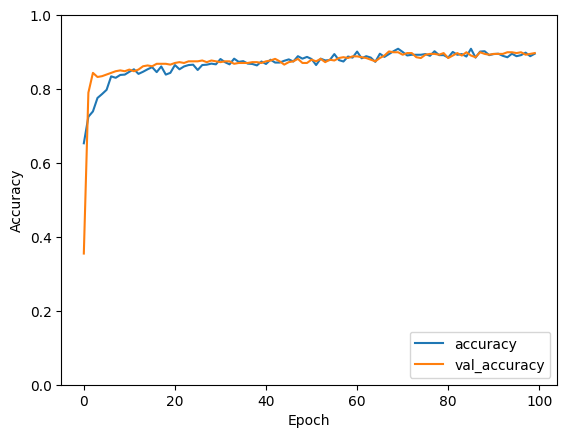

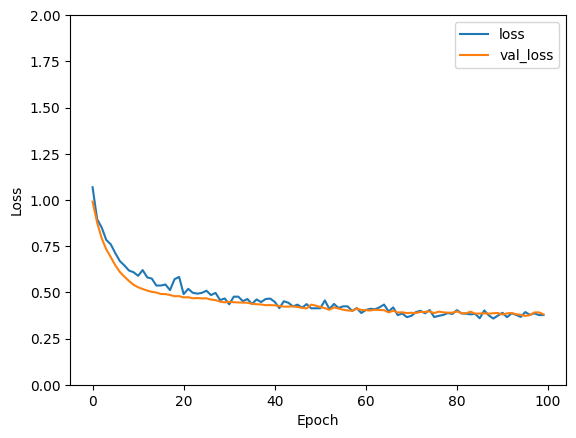

In [ ]:
# Mengevaluasi model
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

# Membuat prediksi menggunakan data testing
y_pred = model.predict(X_test_padded)
predicted_classes = np.argmax(y_pred, axis=1)

# Menampilkan hasil prediksi
print(f"Prediksi: {predicted_classes}")

# Evaluasi hasil prediksi dengan laporan klasifikasi dan matriks kebingungan
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat laporan klasifikasi dalam bentuk tabel
classification_rep = classification_report(y_test, predicted_classes, output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

# Membuat matriks kebingungan dalam bentuk tabel
confusion_mat = confusion_matrix(y_test, predicted_classes)
confusion_df = pd.DataFrame(confusion_mat, index=[f"True_{i}" for i in range(confusion_mat.shape[0])],
                            columns=[f"Pred_{i}" for i in range(confusion_mat.shape[1])])

# Menampilkan laporan klasifikasi sebagai gambar
plt.figure(figsize=(10, 6))
sns.heatmap(classification_df.iloc[:-1, :].T, annot=True, cmap='Blues', cbar=False)
plt.title("Classification Report")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

# Menampilkan matriks kebingungan sebagai gambar
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.yticks(rotation=0)
plt.show()



# Menampilkan grafik akurasi dan loss
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')
plt.show()
